# Non-linear Curve Fitting

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/nonlinear_curve_fitting/nonlinear_curve_fitting.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

<!-- TODO - background introduction for this problem. -->

In this notebook, we use `cofi` to run a non-linear curve fitting problem:

$$f(x)=\exp(a*x)+b$$

## Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

## Define the problem

In [3]:
def my_forward(m, x):
    return np.exp(m[0] * x) + m[1]

def my_jacobian(m, x):
    G=np.zeros([len(x),2])
    G[:,0]=x*np.exp(m[0]*x) # derivative with respect to m[0] 
    G[:,1]=np.ones(len(x))  # derivtavie with respect to m[1]
    return G

def my_residuals(m, x, y):
    yhat = my_forward(m,x)
    return yhat-y

In [4]:
# Choose the "true" parameters.
a_true = 5.0
b_true = 4.0
f_true = 0.1

m_true = [a_true,b_true]
mf_true= [a_true,b_true,f_true]

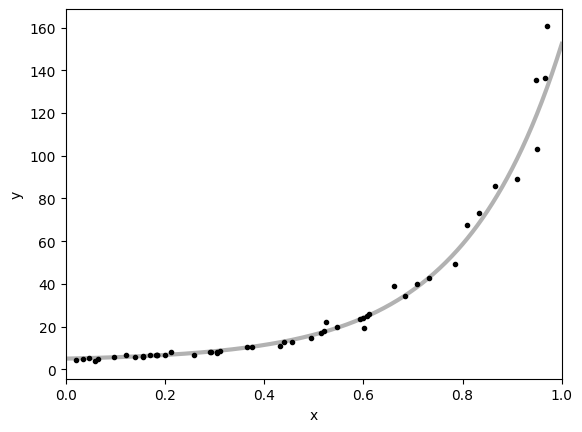

In [5]:
# Generate some synthetic data from the model.
N = 50
x = np.sort(1 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = my_forward(m_true,x)
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 1, 500)
plt.plot(x0, my_forward(m_true,x0), "k", alpha=0.3, lw=3)
plt.xlim(0, 1)
plt.xlabel("x")
plt.ylabel("y");

In [6]:
# define the problem in cofi
inv_problem = BaseProblem()
inv_problem.name = "Curve Fitting"
inv_problem.set_data(y)
inv_problem.set_forward(my_forward, args=[x])
inv_problem.set_jacobian(my_jacobian, args=[x])
inv_problem.set_residual(my_residuals, args=[x,y])
inv_problem.set_initial_model([3,3])

## Example 1. least squares optimizer (levenber marquardt)

In [7]:
inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.least_squares")
inv_options.set_params(method="lm", max_nfev=10)

In [8]:
######## Run it
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

######## Check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.optimize.minimize`: [5.06442618 3.54842172]

Summary for inversion result
SUCCESS
----------------------------
cost: 751.5703778228734
fun: [ 8.46834974e-02 -1.77230955e-02 -5.52853293e-01  8.89806503e-01
  2.91152920e-01 -6.80792317e-01 -1.14702071e+00 -2.15801090e-01
  1.82952940e-01 -5.26482030e-01 -7.76017779e-01 -5.59530381e-01
 -4.95847931e-01 -4.13394792e-01 -5.36314270e-01 -1.56467760e+00
  4.20608348e-01 -1.91245184e-01 -7.95757076e-02  4.30437727e-01
 -1.36307871e-02 -3.20414157e-01 -3.61292253e-01 -1.97016377e-01
  1.47256652e+00  1.95462598e-01  6.42560479e-01  1.17710109e+00
  1.82720280e-01 -5.85651733e-01 -4.32433161e+00 -4.33451431e-01
  1.59207006e-02  4.24747095e-01  5.23801008e+00  2.40244378e-01
 -2.85673020e-01 -6.65912029e+00  1.06971709e+00 -1.41328842e-01
  1.44236334e+00  7.70525925e+00 -4.25388813e+00 -1.75601284e+00
 -1.98652707e+00  1.44619318e+01 -9.86284710e+00  2.35903628e+01
 -2.98371685e-02 -2.11903105e+01]
jac: [[2.2846

## Example 2. emcee

In [9]:
sigma = 10                                     # common noise standard deviation
Cdinv = np.eye(len(y))/(sigma**2)      # inverse data covariance matrix

def my_log_likelihood(m,x,y,Cdinv):
    yhat = my_forward(m,x)
    residual = y-yhat
    return -0.5 * residual @ (Cdinv @ residual).T

In [10]:
m_min = [0,0]             # lower bound for uniform prior
m_max = [10,10]          # upper bound for uniform prior

def my_log_prior(m,m_min,m_max):    # uniform distribution
    for i in range(len(m)):
        if m[i] < m_min[i] or m[i] > m_max[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

In [11]:
nwalkers = 12
ndim = 2
nsteps = 500
walkers_start = np.array([5.,4.]) + 1e-1 * np.random.randn(nwalkers, ndim)

In [12]:
inv_problem.set_log_prior(my_log_prior,args=[m_min,m_max])
inv_problem.set_log_likelihood(my_log_likelihood,args=[x,y,Cdinv])
inv_problem.set_model_shape(ndim)

In [13]:
inv_options = InversionOptions()
inv_options.set_tool("emcee")
inv_options.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start)

######## Run it
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

######## Check result
print(f"The inversion result from `emcee`:")
inv_result.summary()

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


In [14]:
sampler = inv_result.sampler
az_idata = inv_result.to_arviz()

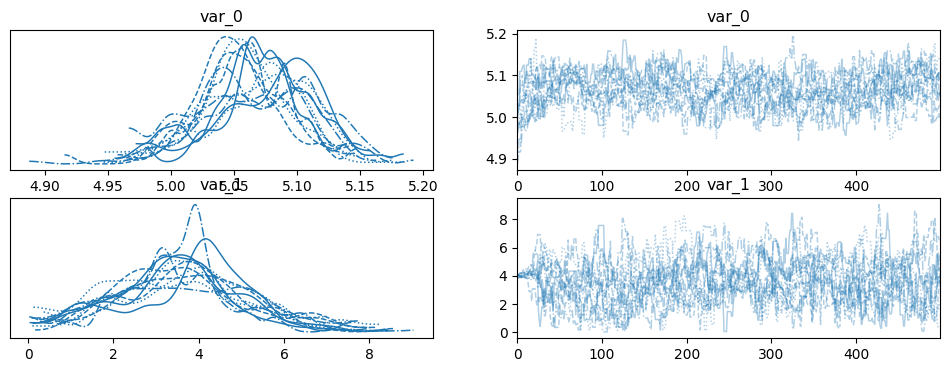

In [15]:
labels = ["m0", "m1"]
az.plot_trace(az_idata);

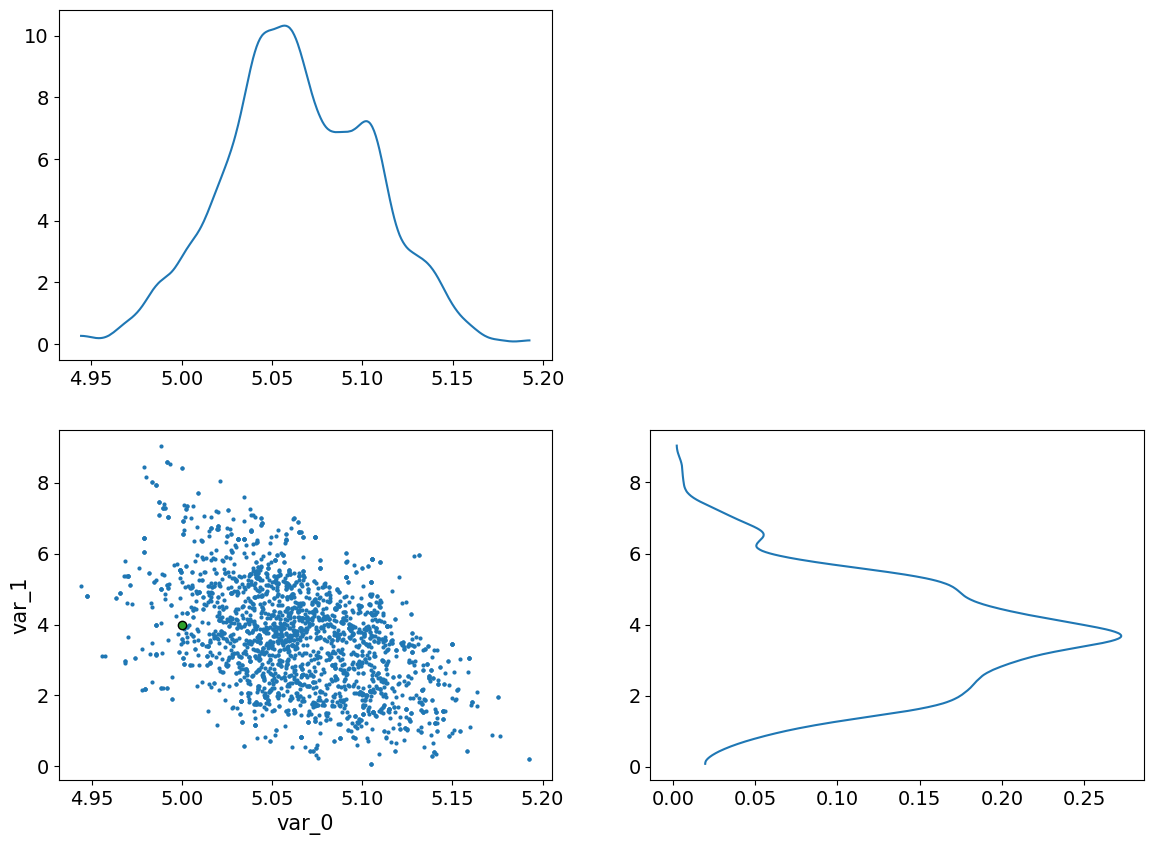

In [16]:
_, axes = plt.subplots(2, 2, figsize=(14,10))
az.plot_pair(
    az_idata.sel(draw=slice(300,None)), 
    marginals=True, 
    reference_values=dict(zip([f"var_{i}" for i in range(2)], m_true   )),
    ax = axes
);

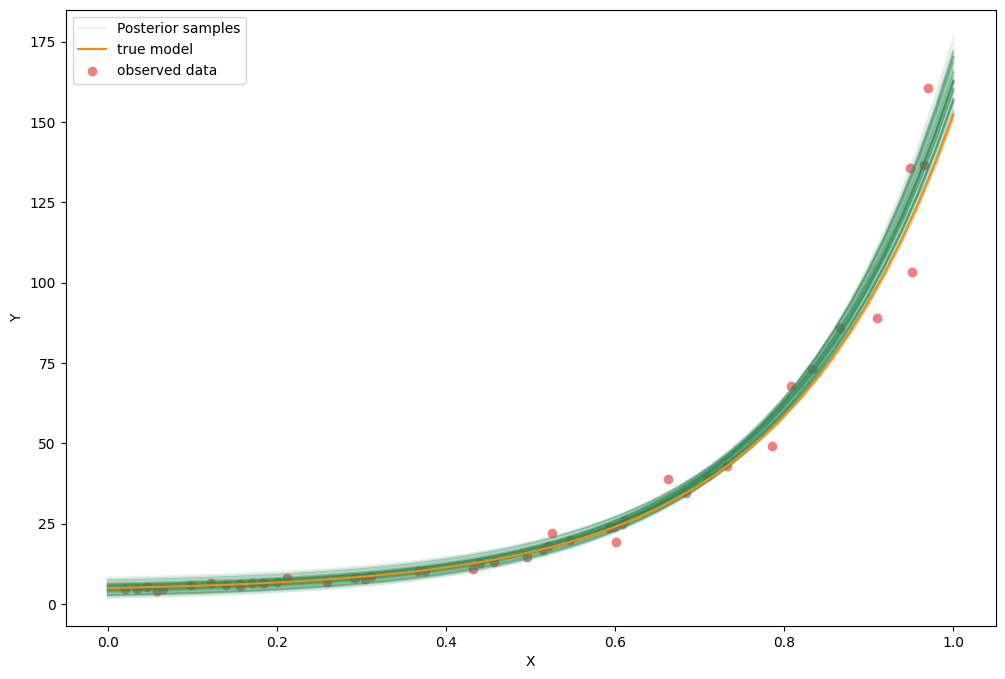

In [17]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble
_x_plot = np.linspace(0,1.0)
_y_plot =  my_forward(m_true,_x_plot)
plt.figure(figsize=(12,8))
sample = flat_samples[0]
_y_synth =  my_forward(sample,_x_plot)
plt.plot(_x_plot, _y_synth, color="seagreen", label="Posterior samples",alpha=0.1)
for ind in inds:
    sample = flat_samples[ind]
    _y_synth =  my_forward(sample,_x_plot)
    plt.plot(_x_plot, _y_synth, color="seagreen", alpha=0.1)
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.scatter(x, y, color="lightcoral", label="observed data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [18]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10
numpy 2.1.3
scipy 1.14.1
matplotlib 3.10.1
emcee 3.1.6
arviz 0.20.0
